## Determine the mean squared error (MSE) of soil moisture hindcasts based on LIM and an AR1 process
<br>

<b>Primary Author:</b>  Meg D. Fowler, CIRES/NOAA PSD <br>
<b>Date:</b>    10 Feb 2020 <br>
<b>Name:</b>    MSE_SoilMoistureHindcasts.ipynb

<br>
<b>Short Description</b> <br>
- A linear inverse model produces output that allows for hindcasts of soil conditions (input as in default case illustrated in LinearInverseModel.ipynb). 
- Forecasts of opportunity are identified based on the magnitude of the projection of the optimal structure onto observed initial conditions. 
- MSE is then computed for these LIM hindcasts, and are compared to error associated with an AR1 process. 
<br><br>
As always, though we have done our best to ensure that this code is error free, bugs are always a possiblity. Use this code at your own risk! But please don't hesitate to reach out to us to suggest corrections/additions. <br>

<br>Note: This script is used for producing data in <i>Fowler and Penland</i> (2019), in prep.<br><br>




### Import libraries

In [12]:
import numpy as np 
from   numpy import linalg as LA
import os
import scipy 
from   scipy import stats 
import pandas as pd
import matplotlib.pyplot as plt
from   matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import numpy.ma as ma
import pickle 
import math
from LIM_analysis import LIM      # Function written for this study


## 1. Get user defined input 
- Should be based on what was run in LinearInverseModel.ipynb 
- For default case as in manuscript, the file path is:  /home/mfowler/Python/pickleFiles/zScores_residST_SM.p
-       The station names are: T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11
-       The tau0 chosen is 7 days 
-       The maxAmp for the field norm is 13 days. For the moisture norm it is 16 days. 

In [7]:
filePath = input("Enter the file path to the pickle file of data: ")

filePath = filePath.strip()   #Commonly wind up with spaces at beginning/end, so just strip those off 
print()


Enter the file path to the pickle file of data:  /home/mfowler/Python/pickleFiles/zScores_residST_SM.p



In [8]:
stationNames = input("What are the station/variable names you would like to use? (Separate by commas) ")
print()


What are the station/variable names you would like to use? (Separate by commas) T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,M1,M2,M3,M4,M5,M6,M7,M8,M9,M10,M11



In [9]:
tau0 = int(input("What lag would you like to use to define the parameters of LIM? "))
print()


What lag would you like to use to define the parameters of LIM? 7



In [10]:
maxAmp = int(input("What was the lag associated with the maximum amplification of the system (Tau_peak)? "))
print()

What was the lag associated with the maximum amplification of the system (Tau_peak)? 13



## 2. Define parameters from LIM 

### 2.1 Read in data 

In [13]:
# Load in pickle file containing user-supplied data 

if os.path.isfile(filePath)==True:
    data   = pickle.load( open( filePath, "rb" ) )
else: 
    print('!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--')
    print('   WARNING: File does not exist! Cannot continue.')
    print('!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--!--')
    

In [14]:
#Define list of variable identifiers as an array of strings
stationIDs = stationNames.split(',')


In [15]:
# Define size of data array 
sizes = np.shape(data)
nDat  = sizes[0]
nT    = sizes[1]


### 2.2 Carry out LIM

In [16]:
#Initial conditions/definitions from LIM 
b_alpha,L,Q,G,c0,cT,u,v,g,periods,decayT = LIM(data,tau0)

#Make diagonal matrix of g
g_diag = np.zeros((nDat, nDat), complex)
np.fill_diagonal(g_diag, g)
#Define Green's function at the peak of the max amplification growth (13 days in this case)
G_tau           = np.dot(u,np.dot((g_diag)**(maxAmp/tau0),np.transpose(v)))

# ---- EOF analysis of GtG ---- #
matr = np.dot(np.transpose(G_tau),G_tau)

eigVal_GTG, eigVec_GTG = LA.eig(matr)

#Sort the eigenvalues in order 
iSort_GTG  = eigVal_GTG.argsort()[::-1]   
eigVal_GTG = eigVal_GTG[iSort_GTG] 
eigVec_GTG = eigVec_GTG[:,iSort_GTG]

#The optimal structure is the first eigenVector of the matrix GtG. 
optimStruct = eigVec_GTG[:,0].real

#Get the forecast by projecting G(tau) onto that optimal structure 
forecastStruct = np.dot(G_tau.real,optimStruct)


/home/mfowler/Python/GitHub_Ready/LIM_analysis.py:105: RuntimeWarning: divide by zero encountered in true_divide
  periods = (2 * np.pi) / b_alpha.imag


## 3. Define forecasts of opportunity

In [17]:
# So first, get the projection of the optimal structure onto the field at each time 
optProj   = np.full([nT], np.nan)

for iT in range(nT):
    optProj[iT]   = np.nansum(np.transpose(optimStruct)    * data[:,iT])  #For matrix multiplication with nan, take nansum after *



In [18]:
# Define the cutoff for the top tercile
projTrcile = np.nanpercentile(np.abs(optProj),66.66)   # Cutoff defined as top tercile here (can be changed)
print('The cutoff value is: ', projTrcile)

#Find days where the value of the projection is above the cutoff 
iProj = np.where(abs(optProj)>=projTrcile)
topDays = iProj[0]



The cutoff value is:  0.6437902607375066


Make a histogram of the projection magnitudes, and add line for cutoff value 

Text(0.5, 1.0, 'Histogram definig Forecasts of Opportunity')

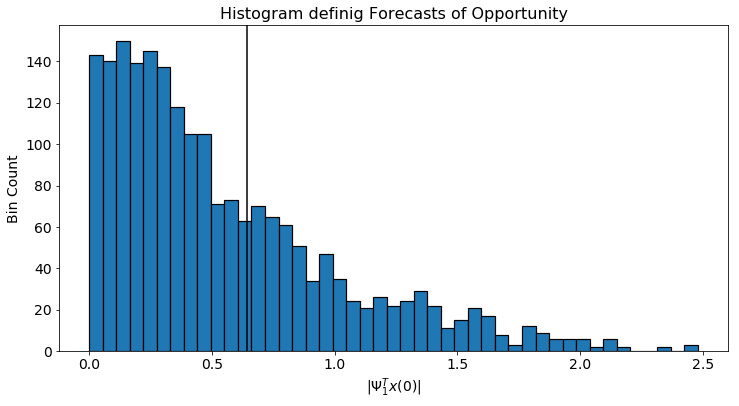

In [20]:
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(12,6)

# Field Norm 
ax1.hist(np.abs(optProj),bins=np.int(np.round(np.sqrt(len(optProj)))),edgecolor='black', linewidth=1.2)
ax1.axvline(projTrcile,color='k')
ax1.set_xlabel(r'$ |\Psi^{T}_1 x(0)|$',fontsize=14)
ax1.set_ylabel('Bin Count',fontsize=14)
ax1.tick_params(labelsize=14)
ax1.set_title('Histogram definig Forecasts of Opportunity',fontsize=16)

## 4. Get error estimates for LIM-based forecasts 

In [21]:
# --- ERROR IN THE LIM FORECAST --- #

#   Create array of Tau's to test 
Tau_arr = np.arange(75)

#   Create empty arrays to store values in 
meanErr_fcst         = np.full([nDat, len(Tau_arr)], np.nan) 
meanErr_fcst_optDays = np.full([nDat, len(Tau_arr)], np.nan) 

for iTau in range(len(Tau_arr)):   #Loop over number of lags to be computed 
    # Set up initial values as zero for time-averaged values 
    eps2_L = np.full([nDat],0.)
    ncor_L = np.full([nDat],0.)
    # Set up similar values for computing the error only on days where projection is good
    eps2_optL = np.full([nDat],0.)
    ncor_optL = np.full([nDat],0.)
    
    #Define Green function at this lag 
    G_tau    = np.dot(u,np.dot((g_diag)**(Tau_arr[iTau]/tau0),np.transpose(v))).real
    
    #Define empty array to store forecast at each time
    fcst     = np.full([nDat,nT-Tau_arr[iTau]], np.nan)
    
    for iT in range(nT-Tau_arr[iTau]):    #Loop over timesteps 
        
        # --- Get forecast data --- #
        #If there is any missing data at this time...
        if ( np.isnan(data[:,iT]).any() ): 
            #Indices where NaNs are *not*
            iNan = np.where(~np.isnan(data[:,iT]))
            
            #Make replica matrix replacing NaNs with zeros so that it won't count for other stations (but is computed)
            replZeros          = np.zeros(np.shape(data[:,iT]))
            replZeros[iNan[0]] = data[iNan[0],iT]
            
            #Get forecast using zeros array so that stations w/o NaN are still computed properly 
            fcst[:,iT] = np.dot(G_tau, replZeros)
            
            #Replacing stations that had missing data with a NaN (no forecast if no data)
            fcst[np.where(np.isnan(data[:,iT])),iT] = np.nan
        else:     
            #If no data is missing, just compute forecast as normal - G(Tau) * X(:,t)
            fcst[:,iT] = np.dot(G_tau, data[:,iT])
            
        # -- Build up mean squared error estimates for the LIM forecast at each station -- #
        for iSt in range(nDat):     #Loop over stations 
            # Make sure data exists
            if ( np.isfinite( data[iSt,iT] ) and np.isfinite( data[iSt,iT+Tau_arr[iTau]] ) ):     
                fcst_Err    = data[iSt,iT+Tau_arr[iTau]] - fcst[iSt,iT]
                eps2_L[iSt] = np.nansum([fcst_Err**2, eps2_L[iSt]])
                ncor_L[iSt] = ncor_L[iSt] + 1
                
                if ( (iT+Tau_arr[iTau]) in topDays ):
                    eps2_optL[iSt] = np.nansum([fcst_Err**2, eps2_optL[iSt]])
                    ncor_optL[iSt] = ncor_optL[iSt] + 1

    # Compute mean squared error for every station over the period at this lag 
    meanErr_fcst[:,iTau]         = eps2_L/ncor_L 
    meanErr_fcst_optDays[:,iTau] = eps2_optL/ncor_optL
    
# Set first error estimate to zero: 
meanErr_fcst[:,0]         = 0
meanErr_fcst_optDays[:,0] = 0

#Normalize by the variance at each station 
for iSt in range(nDat):
    meanErr_fcst[iSt,:]         = meanErr_fcst[iSt,:]/np.nanvar(data[iSt,:])
    meanErr_fcst_optDays[iSt,:] = meanErr_fcst_optDays[iSt,:]/np.nanvar(data[iSt, topDays])


## 5. Get errors associated with an AR1 process 

### 5.1 First, get e-folding times of auto-correlation function
- NOTE: This section may take a while to run. It's not a bad idea to add in a cell here to save the e-folding times as a pickle file that can be read in next time you need the script. 

In [22]:
def auto_corr(lags,stationData):
    #Define empty array for each station 
    autoCorr = np.full([len(lags)],np.nan)
    
    #The denominator should always be the same, so calculate that outside of the loop over lags
    allPairs  = 0
    denom     = 0.0
    
    for iDen in range(len(stationData)): 
        denom = np.nansum([denom, stationData[iDen]**2])
        if np.isfinite(stationData[iDen])==True:
            allPairs = allPairs+1
            
    denom = denom/allPairs
    
    # Loop over lags 
    for iK in range(len(lags)): 
        numerator = 0.0 
        realPairs = 0  

        for iObs in range(len(stationData)-(iK+1)):
            numerator = np.nansum([numerator, (stationData[iObs]*stationData[iObs+iK])])

            if ((np.isfinite(stationData[iObs])==True) and (np.isfinite(stationData[iObs+iK])==True)): 
                realPairs = realPairs+1

        autoCorr[iK] = (numerator/realPairs)/denom

        if (iK % 100)==0:
            print('Done with lag: ', iK+1, ' Days')

    return autoCorr


In [24]:
#Get information from the autocorrelation function; in this case, the e-folding time 

#Lags out to 1 year 
lags       = np.arange(365)

#Empty array to store e-folding times in 
eFoldTimes = np.full([nDat],np.nan)

for iSt in range(nDat):
    #Get the auto-correlation function from previoustly defined function 
    autoCorr_station = auto_corr(lags, data[iSt,:])

    #Get the index where the autoCorrelation function hits its e-folding time and store that 
    iE              = np.where(autoCorr_station <= (autoCorr_station[0]/np.e))
    eFoldTimes[iSt] = iE[0][0]

    print('Done with data set: ', stationIDs[iSt])

Done with lag:  1  Days
Done with lag:  101  Days
Done with lag:  201  Days
Done with lag:  301  Days
Done with station  T1
Done with lag:  1  Days
Done with lag:  101  Days
Done with lag:  201  Days
Done with lag:  301  Days
Done with station  T2
Done with lag:  1  Days
Done with lag:  101  Days
Done with lag:  201  Days
Done with lag:  301  Days
Done with station  T3
Done with lag:  1  Days
Done with lag:  101  Days
Done with lag:  201  Days
Done with lag:  301  Days
Done with station  T4
Done with lag:  1  Days
Done with lag:  101  Days
Done with lag:  201  Days
Done with lag:  301  Days
Done with station  T5
Done with lag:  1  Days
Done with lag:  101  Days
Done with lag:  201  Days
Done with lag:  301  Days
Done with station  T6
Done with lag:  1  Days
Done with lag:  101  Days
Done with lag:  201  Days
Done with lag:  301  Days
Done with station  T7
Done with lag:  1  Days
Done with lag:  101  Days
Done with lag:  201  Days
Done with lag:  301  Days
Done with station  T8
Done wit

### 5.2 Get actual errors 

In [27]:
# --- ERRORS THAT ARISE FROM A SIMPLE AR1 PROCESS --- #

#Create array of Tau's to test 
Tau_arr = np.arange(75)
#Create empty arrays to store values in 
meanErr_AR1          = np.full([nDat,len(Tau_arr)], np.nan) 
meanErr_AR1_optDays  = np.full([nDat,len(Tau_arr)], np.nan) 

for iTau in range(len(Tau_arr)):
    # --- Get error from AR1 process --- #
    
    #Define a_Tau for AR1 error estimates, based on e-folding time of auto-correlation function 
    a_Tau  = np.exp((-1/eFoldTimes) * Tau_arr[iTau])

    for iSt in range(nDat):
        ncor_AR1 = 0.
        eps2_AR1 = 0.
        esp2_optAR1 = 0.
        ncor_optAR1 = 0. 
        ar1 = a_Tau[iSt] * data[iSt,:]     #Define the AR1 process forecast at this station
        
        for iT in range(nT-Tau_arr[iTau]): 
            # Make sure data is finite
            if ( np.isfinite( data[iSt,iT] ) and np.isfinite( data[iSt,iT+Tau_arr[iTau]] ) ):
                eps2_AR1 += ( data[iSt,iT+Tau_arr[iTau]] - ar1[iT] )**2
                ncor_AR1 += 1      
                
                if ( (iT+Tau_arr[iTau]) in topDays ):
                    esp2_optAR1 += ( data[iSt,iT+Tau_arr[iTau]] - ar1[iT] )**2
                    ncor_optAR1 += 1

        # Estimate mean squared error at this station and lag 
        meanErr_AR1[iSt,iTau]         = eps2_AR1/np.float(ncor_AR1)
        meanErr_AR1_optDays[iSt,iTau] = esp2_optAR1/np.float(ncor_optAR1)

#Normalize by the variance at each station 
for iSt in range(nDat):
    meanErr_AR1[iSt,:]         = meanErr_AR1[iSt,:]/np.nanvar(data[iSt,:])
    meanErr_AR1_optDays[iSt,:] = meanErr_AR1_optDays[iSt,:]/np.nanvar(data[iSt,topDays])
    

## 6. Get expected error (a priori estimate from LIM)

In [29]:
# --- LIM EXPECTED ERROR VARIANCE --- # 

#Create array of Tau's to test 
Tau_arr = np.arange(75)

all_StationErr = np.full([nDat, len(Tau_arr)], np.nan)  #Empty array to store station errors in

for iTau in range(len(Tau_arr)):
    #Define Green function at this lag 
    G_tau    = np.dot(u,np.dot((g_diag)**(Tau_arr[iTau]/tau0),np.transpose(v))).real
    
    #Get station expected error variance 
    errEqn = c0 - np.dot(G_tau, np.dot(c0, np.transpose(G_tau)))
    
    for iSt in range(nDat):
        all_StationErr[iSt, iTau] = errEqn[iSt, iSt]

#Set initial value to zero
all_StationErr[:,0] = 0

#Normalize by the variance at each station 
for iSt in range(nDat):
    all_StationErr[iSt,:] = all_StationErr[iSt,:]/np.nanvar(data[iSt,:])


## 7. Plot MSE estimates out to a two week lead time 

In [36]:
numPlots = math.ceil(nDat/4)

(0.0, 3.0, 0.0, 3.0)

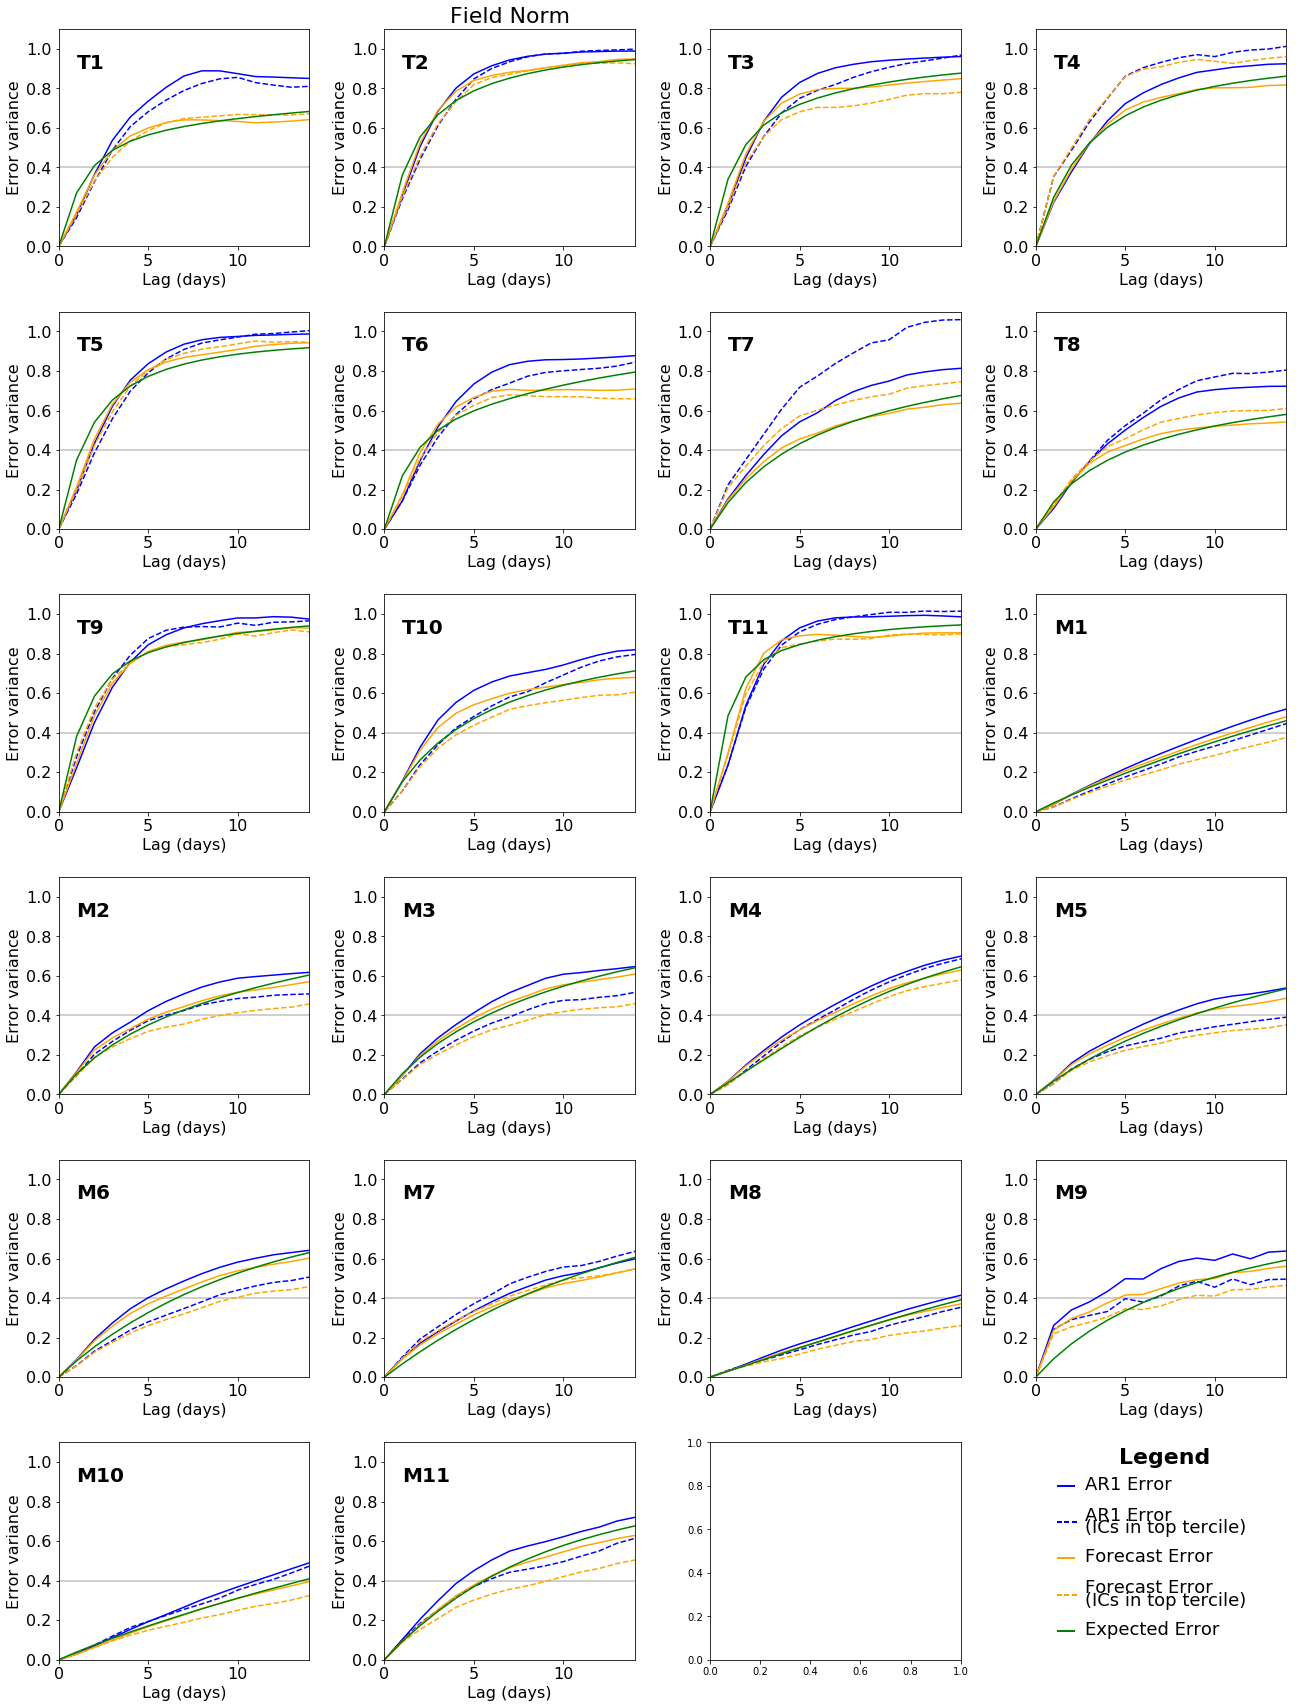

In [39]:
fig, axs = plt.subplots(numPlots,4, figsize=(22, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3,wspace=0.3)

axs = axs.ravel()

for i in range(nDat):
    axs[i].axhline(0.4, color='silver')
    axs[i].plot(meanErr_AR1[i,:],'b')
    axs[i].plot(meanErr_AR1_optDays[i,:],'b--')
    axs[i].plot(meanErr_fcst[i,:],'orange')
    axs[i].plot(meanErr_fcst_optDays[i,:],'--',color='orange')
    axs[i].plot(all_StationErr[i,:],'green')
    axs[i].set_ylim([0, 1.1])
    axs[i].set_xlim([0, 14])
    axs[i].set_xlabel('Lag (days)',fontsize=16)
    axs[i].set_ylabel('Error variance',fontsize=16)
    axs[i].tick_params(labelsize=16)
    axs[i].text(1,0.9,stationIDs[i],fontsize=20,weight='bold')
    
    if i==1:
        axs[i].set_title('Field Norm', fontsize=22)

# Plot legend box 
# THIS SECTION NEEDS TO BE ADJUSTED ACCORDING TO USER NEEDS 
#    You will likely want to change which subplot you want to plot the legend in
#    Depending on number of plots (and thus size of each subplot), you'll need to change the fontsize 

legInd = (numPlots*4)-1   #Which subplot do you want to plot the legend in? (ASSUMED TO BE LAST SUBPLOT)

axs[legInd].set_ylim([0,3])
axs[legInd].set_xlim([0,3])
axs[legInd].text(1,2.7,'Legend',fontsize=22,weight='bold')
# Plot lines 
axs[legInd].plot(0.31,2.4,color='blue',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[legInd].plot(0.35,2.4,color='blue',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[legInd].plot(0.39,2.4,color='blue',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[legInd].plot(0.43,2.4,color='blue',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[legInd].plot(0.47,2.4,color='blue',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[legInd].text(0.59,2.35,'AR1 Error',fontsize=18)

axs[legInd].plot(0.31,1.9,color='blue',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[legInd].plot(0.40,1.9,color='blue',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[legInd].plot(0.49,1.9,color='blue',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[legInd].text(0.59,1.92,'AR1 Error',fontsize=18)
axs[legInd].text(0.59,1.75,'(ICs in top tercile)',fontsize=18)

axs[legInd].plot(0.31,1.4,color='orange',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[legInd].plot(0.35,1.4,color='orange',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[legInd].plot(0.39,1.4,color='orange',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[legInd].plot(0.43,1.4,color='orange',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[legInd].plot(0.47,1.4,color='orange',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[legInd].text(0.59,1.35,'Forecast Error',fontsize=18)

axs[legInd].plot(0.31,0.9,color='orange',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[legInd].plot(0.40,0.9,color='orange',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[legInd].plot(0.49,0.9,color='orange',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[legInd].text(0.59,0.92,'Forecast Error ',fontsize=18)
axs[legInd].text(0.59,0.75,'(ICs in top tercile)',fontsize=18)

axs[legInd].plot(0.31,0.4,color='green',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[legInd].plot(0.35,0.4,color='green',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[legInd].plot(0.39,0.4,color='green',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[legInd].plot(0.43,0.4,color='green',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[legInd].plot(0.47,0.4,color='green',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[legInd].text(0.59,0.35,'Expected Error',fontsize=18)
# Remove tick parks for last plot
axs[legInd].tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off
axs[legInd].axis('off')


## 8. CASE SPECIFIC: Moisture norm 
- In the manuscript, Fowler and Penland (2020; in prep), we not only applied the field norm as above, but also a mositure norm. This version of the model is elaborated on below. <b>This is simply for illustration</b>; your own data will need careful treatment and consideration of applying a different norm. 
- This section assumes that Section 1 above has been run with the default data. 

### 8.1 Get LIM parameters

In [40]:
#Initial conditions/definitions from LIM 
b_alpha,L,Q,G,c0,cT,u,v,g,periods,decayT = LIM(data, tau0)

#Make diagonal matrix of g
g_diag = np.zeros((np.shape(data)[0], np.shape(data)[0]), complex)
np.fill_diagonal(g_diag, g)

G_tau_M = np.dot(u,np.dot((g_diag)**(maxAmp/tau0),np.transpose(v)))  #Peak growth now at 16 days 
G_m     = G_tau_M[11:22,:]

# ---- EOF analysis of GtG using the moisture norm ---- #
matr_M = np.dot(np.transpose(G_m),G_m)

eigVal_GTG_M, eigVec_GTG_M = LA.eig(matr_M)

#Sort the eigenvalues in order 
iSort_GTG_M  = eigVal_GTG_M.argsort()[::-1]   
eigVal_GTG_M = eigVal_GTG_M[iSort_GTG_M] 
eigVec_GTG_M = eigVec_GTG_M[:,iSort_GTG_M]

#The optimal strcture based on the moisture norm version of GtG 
optimStruct_Mnorm = eigVec_GTG_M[:,0].real

#Get forecast by projecting the mositure optimal structure onto the original G(tau)
forecast_Mnorm = np.dot(G_tau_M.real,optimStruct_Mnorm)



/home/mfowler/Python/GitHub_Ready/LIM_analysis.py:105: RuntimeWarning: divide by zero encountered in true_divide
  periods = (2 * np.pi) / b_alpha.imag


### 8.2 Define forecasts of opportunity

In [42]:
# First, get the projection of the optimal structure onto the field at each time 
optProj_Mnorm   = np.full([np.shape(data)[1]], np.nan)

for iT in range(nT):
    optProj_Mnorm[iT]    = np.nansum(optimStruct_Mnorm    * data[:,iT])  #For matrix multiplication with nan, take nansum after *


In [43]:
# Define the cutoff for the top tercile
projTrcile_Mnorm = np.nanpercentile(np.abs(optProj_Mnorm),66.66)
print('The cutoff value is: ', projTrcile_Mnorm)

#Find days where the value of the projection is above the cutoff 
iProj_M = np.where(abs(optProj_Mnorm)>=projTrcile_Mnorm)
topDays_Mnorm = iProj_M[0]


The cutoff value is:  0.7264288871984924


Text(0.5, 1.0, 'Histogram definig Forecasts of Opportunity')

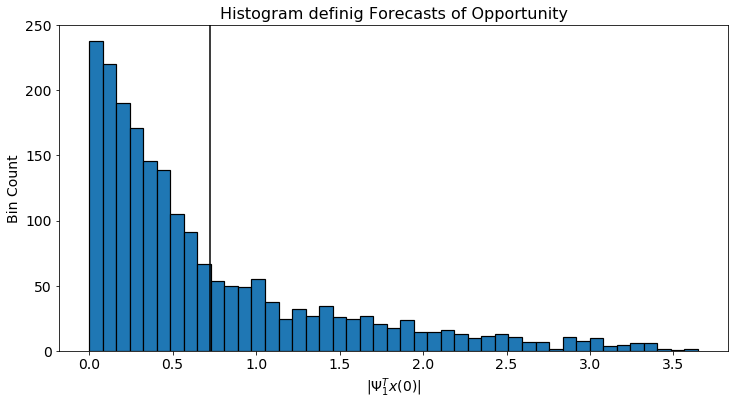

In [44]:
fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(12,6)

# Field Norm 
ax1.hist(np.abs(optProj_Mnorm),bins=np.int(np.round(np.sqrt(len(optProj_Mnorm)))),edgecolor='black', linewidth=1.2)
ax1.axvline(projTrcile_Mnorm,color='k')
ax1.set_xlabel(r'$ |\Psi^{T}_1 x(0)|$',fontsize=14)
ax1.set_ylabel('Bin Count',fontsize=14)
ax1.tick_params(labelsize=14)
ax1.set_title('Histogram definig Forecasts of Opportunity',fontsize=16)

### 8.3 Define error associated with LIM hindcasts

In [45]:
# --- ERROR IN THE LIM FORECAST --- #

#   Create array of Tau's to test 
Tau_arr = np.arange(75)

#   Create empty arrays to store values in 
meanErr_fcst_Mnorm         = np.full([nDat, len(Tau_arr)], np.nan) 
meanErr_fcst_optDays_Mnorm = np.full([nDat, len(Tau_arr)], np.nan) 

for iTau in range(len(Tau_arr)):   #Loop over number of lags to be computed 
    # Set up initial values as zero for time-averaged values 
    eps2_L = np.full([nDat],0.)
    ncor_L = np.full([nDat],0.)
    # Set up similar values for computing the error only on days where projection is good
    eps2_optL = np.full([nDat],0.)
    ncor_optL = np.full([nDat],0.)
    
    #Define Green function at this lag 
    G_tau    = np.dot(u,np.dot((g_diag)**(Tau_arr[iTau]/tau0),np.transpose(v))).real
    
    #Define empty array to store forecast at each time
    fcst     = np.full([nDat,nT-Tau_arr[iTau]], np.nan)
    
    for iT in range(nT-Tau_arr[iTau]):    #Loop over timesteps 
        
        # --- Get forecast data --- #
        #If there is any missing data at this time...
        if ( np.isnan(data[:,iT]).any() ): 
            #Indices where NaNs are *not*
            iNan = np.where(~np.isnan(data[:,iT]))
            
            #Make replica matrix replacing NaNs with zeros so that it won't count for other stations (but is computed)
            replZeros          = np.zeros(np.shape(data[:,iT]))
            replZeros[iNan[0]] = data[iNan[0],iT]
            
            #Get forecast using zeros array so that stations w/o NaN are still computed properly 
            fcst[:,iT] = np.dot(G_tau, replZeros)
            
            #Replacing stations that had missing data with a NaN (no forecast if no data)
            fcst[np.where(np.isnan(data[:,iT])),iT] = np.nan
        else:     
            #If no data is missing, just compute forecast as normal - G(Tau) * X(:,t)
            fcst[:,iT] = np.dot(G_tau, data[:,iT])
            
        # -- Build up mean squared error estimates for the LIM forecast at each station -- #
        for iSt in range(nDat):     #Loop over stations 
            # Make sure data exists
            if ( np.isfinite( data[iSt,iT] ) and np.isfinite( data[iSt,iT+Tau_arr[iTau]] ) ):     
                fcst_Err    = data[iSt,iT+Tau_arr[iTau]] - fcst[iSt,iT]
                eps2_L[iSt] = np.nansum([fcst_Err**2, eps2_L[iSt]])
                ncor_L[iSt] = ncor_L[iSt] + 1
                
                if ( (iT+Tau_arr[iTau]) in topDays_Mnorm ):
                    eps2_optL[iSt] = np.nansum([fcst_Err**2, eps2_optL[iSt]])
                    ncor_optL[iSt] = ncor_optL[iSt] + 1

    # Compute mean squared error for every station over the period at this lag 
    meanErr_fcst_Mnorm[:,iTau]         = eps2_L/ncor_L 
    meanErr_fcst_optDays_Mnorm[:,iTau] = eps2_optL/ncor_optL
    
# Set first error estimate to zero: 
meanErr_fcst_Mnorm[:,0]         = 0
meanErr_fcst_optDays_Mnorm[:,0] = 0

#Normalize by the variance at each station 
for iSt in range(nDat):
    meanErr_fcst_Mnorm[iSt,:]         = meanErr_fcst_Mnorm[iSt,:]/np.nanvar(data[iSt,:])
    meanErr_fcst_optDays_Mnorm[iSt,:] = meanErr_fcst_optDays_Mnorm[iSt,:]/np.nanvar(data[iSt, topDays_Mnorm])




### 8.4 Get error associated with an AR1 process (using e-folding times computed above)

In [46]:
# --- ERRORS THAT ARISE FROM A SIMPLE AR1 PROCESS --- #

#Create array of Tau's to test 
Tau_arr = np.arange(75)
#Create empty arrays to store values in 
meanErr_AR1_Mnorm          = np.full([nDat,len(Tau_arr)], np.nan) 
meanErr_AR1_optDays_Mnorm  = np.full([nDat,len(Tau_arr)], np.nan) 

for iTau in range(len(Tau_arr)):
    # --- Get error from AR1 process --- #
    
    #Define a_Tau for AR1 error estimates, based on e-folding time of auto-correlation function 
    a_Tau  = np.exp((-1/eFoldTimes) * Tau_arr[iTau])

    for iSt in range(nDat):
        ncor_AR1 = 0.
        eps2_AR1 = 0.
        esp2_optAR1 = 0.
        ncor_optAR1 = 0. 
        ar1 = a_Tau[iSt] * data[iSt,:]     #Define the AR1 process forecast at this station
        
        for iT in range(nT-Tau_arr[iTau]): 
            # Make sure data is finite
            if ( np.isfinite( data[iSt,iT] ) and np.isfinite( data[iSt,iT+Tau_arr[iTau]] ) ):
                eps2_AR1 += ( data[iSt,iT+Tau_arr[iTau]] - ar1[iT] )**2
                ncor_AR1 += 1      
                
                if ( (iT+Tau_arr[iTau]) in topDays_Mnorm ):
                    esp2_optAR1 += ( data[iSt,iT+Tau_arr[iTau]] - ar1[iT] )**2
                    ncor_optAR1 += 1

        # Estimate mean squared error at this station and lag 
        meanErr_AR1_Mnorm[iSt,iTau]         = eps2_AR1/np.float(ncor_AR1)
        meanErr_AR1_optDays_Mnorm[iSt,iTau] = esp2_optAR1/np.float(ncor_optAR1)

#Normalize by the variance at each station 
for iSt in range(nDat):
    meanErr_AR1_Mnorm[iSt,:]         = meanErr_AR1_Mnorm[iSt,:]/np.nanvar(data[iSt,:])
    meanErr_AR1_optDays_Mnorm[iSt,:] = meanErr_AR1_optDays_Mnorm[iSt,:]/np.nanvar(data[iSt,topDays_Mnorm])
    

### 8.5 LIM expected error (a priori estimate)

In [48]:
# --- LIM EXPECTED ERROR VARIANCE --- # 

#Create array of Tau's to test 
Tau_arr = np.arange(75)

all_StationErr = np.full([nDat, len(Tau_arr)], np.nan)  #Empty array to store station errors in

for iTau in range(len(Tau_arr)):
    #Define Green function at this lag 
    G_tau    = np.dot(u,np.dot((g_diag)**(Tau_arr[iTau]/tau0),np.transpose(v))).real
    
    #Get station expected error variance 
    errEqn = c0 - np.dot(G_tau, np.dot(c0, np.transpose(G_tau)))
    
    for iSt in range(nDat):
        all_StationErr[iSt, iTau] = errEqn[iSt, iSt]

#Set initial value to zero
all_StationErr[:,0] = 0

#Normalize by the variance at each station 
for iSt in range(nDat):
    all_StationErr[iSt,:] = all_StationErr[iSt,:]/np.nanvar(data[iSt,:])


### 8.6 Plot MSE estimates for just moisture (as in manuscript figure)

(0.0, 3.0, 0.0, 3.0)

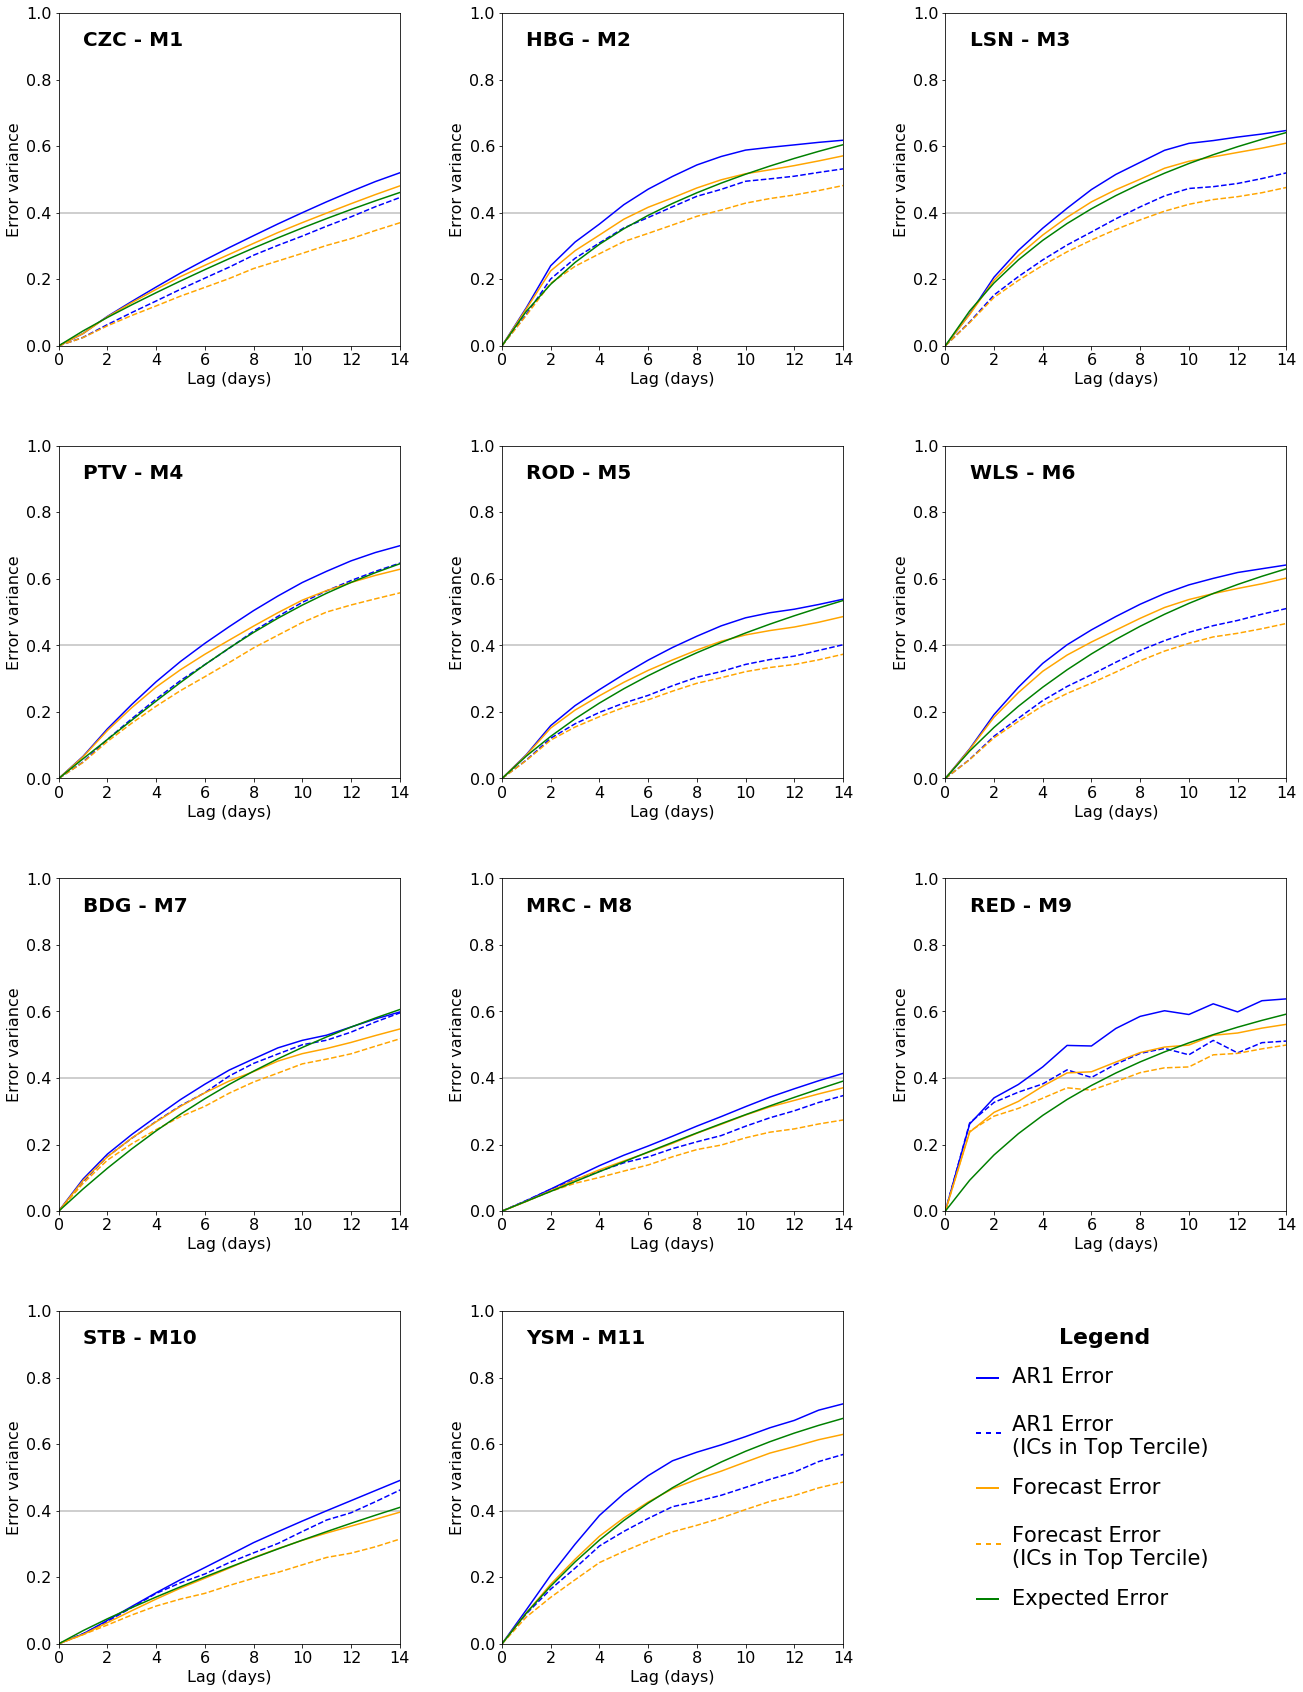

In [49]:
fig, axs = plt.subplots(4,3, figsize=(22, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3,wspace=0.3)
labels = ['CZC','HBG','LSN','PTV','ROD','WLS','BDG','MRC','RED','STB','YSM']

axs = axs.ravel()

for i in range(11):
    axs[i].axhline(0.4, color='silver')
    axs[i].plot(meanErr_AR1_Mnorm[i+11,:],'b')
    axs[i].plot(meanErr_AR1_optDays_Mnorm[i+11,:],'b--')
    axs[i].plot(meanErr_fcst_Mnorm[i+11,:],'orange')
    axs[i].plot(meanErr_fcst_optDays_Mnorm[i+11,:],'--',color='orange')
    axs[i].plot(all_StationErr[i+11,:],'green')
    axs[i].set_ylim([0, 1])
    axs[i].set_xlim([0, 14])
    axs[i].set_xlabel('Lag (days)',fontsize=16)
    axs[i].set_ylabel('Error variance',fontsize=16)
    axs[i].tick_params(labelsize=16)
    axs[i].text(1,0.9,labels[i]+' - M'+str(i+1),fontsize=20,weight='bold')

# Plot legend box 
axs[11].set_ylim([0,3])
axs[11].set_xlim([0,3])
axs[11].text(1,2.7,'Legend',fontsize=22,weight='bold')
# Plot lines 
axs[11].plot(0.31,2.4,color='blue',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[11].plot(0.35,2.4,color='blue',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[11].plot(0.39,2.4,color='blue',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[11].plot(0.43,2.4,color='blue',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[11].plot(0.47,2.4,color='blue',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[11].text(0.59,2.35,'AR1 Error',fontsize=21)

axs[11].plot(0.31,1.9,color='blue',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[11].plot(0.40,1.9,color='blue',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[11].plot(0.49,1.9,color='blue',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[11].text(0.59,1.92,'AR1 Error',fontsize=21)
axs[11].text(0.59,1.71,'(ICs in Top Tercile)',fontsize=21)

axs[11].plot(0.31,1.4,color='orange',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[11].plot(0.35,1.4,color='orange',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[11].plot(0.39,1.4,color='orange',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[11].plot(0.43,1.4,color='orange',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[11].plot(0.47,1.4,color='orange',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[11].text(0.59,1.35,'Forecast Error',fontsize=21)

axs[11].plot(0.31,0.9,color='orange',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[11].plot(0.40,0.9,color='orange',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[11].plot(0.49,0.9,color='orange',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[11].text(0.59,0.92,'Forecast Error ',fontsize=21)
axs[11].text(0.59,0.71,'(ICs in Top Tercile)',fontsize=21)

axs[11].plot(0.31,0.4,color='green',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[11].plot(0.35,0.4,color='green',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[11].plot(0.39,0.4,color='green',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[11].plot(0.43,0.4,color='green',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[11].plot(0.47,0.4,color='green',linestyle='none',markeredgewidth=2,marker=0,markersize=5)
axs[11].text(0.59,0.35,'Expected Error',fontsize=21)
# Remove tick parks for last plot
axs[11].tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelleft=False,
    labelbottom=False) # labels along the bottom edge are off
axs[11].axis('off')
   